# Машинное обучение, РЭШ

## [Практическое задание 3. Градиентный спуск своими руками](https://www.youtube.com/watch?v=dQw4w9WgXcQ)

### Общая информация
Дата выдачи: 17.11.2022

Дедлайн: 23:59MSK 24.11.2022

### О задании

В данном задании необходимо реализовать обучение линейной регрессии с помощью различных вариантов градиентного спуска.


### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

Неэффективная реализация кода может негативно отразиться на оценке.

Все ответы должны сопровождаться кодом или комментариями о том, как они были получены.


### Формат сдачи
Задания загружаются на my.nes. Присылать необходимо ноутбук с выполненным заданием. 

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

**Оценка**: ...

## Реализация градиентного спуска

Реализуйте линейную регрессию с функцией потерь MSE, обучаемую с помощью:

**Задание 1 (1 балл)** Градиентного спуска;

**Задание 2.1 (2 балла)** Стохастического градиентного спуска + Batch SGD;

**Задание 2.2 (2 балла)** SGD Momentum;

**Бонусное задание (2 балл)** Adagrad, RMSProp, Adam;

Во всех пунктах необходимо соблюдать следующие условия:

* Все вычисления должны быть векторизованы;
* Циклы средствами python допускается использовать только для итераций градиентного спуска;
* В качестве критерия останова необходимо использовать (одновременно):

    * проверку на евклидовую норму разности весов на двух соседних итерациях (например, меньше некоторого малого числа порядка $10^{-6}$, задаваемого параметром `tolerance`);
    * достижение максимального числа итераций (например, 10000, задаваемого параметром `max_iter`).
* Чтобы проследить, что оптимизационный процесс действительно сходится, будем использовать атрибут класса `loss_history` — в нём после вызова метода `fit` должны содержаться значения функции потерь для всех итераций, начиная с первой (до совершения первого шага по антиградиенту);
* Инициализировать веса можно случайным образом или нулевым вектором. 


Ниже приведён шаблон класса, который должен содержать код реализации каждого из методов.

In [122]:
def pprint(*args, **kwargs):
    print(">>", *args, **kwargs)

In [313]:
import numpy as np
import pandas as pd

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score


class LinearReg(BaseEstimator):
    def __init__(self, gd_type='full', optimizer_type='full', loss_function="mse",
                 tolerance=1e-4, max_iter=1000, w0=None, eta=1e-2, batch_size=1, alpha_momentum=1e-2):
        """
        gd_type: 'full' or 'stochastic'
        tolerance: for stopping gradient descent
        max_iter: maximum number of steps in gradient descent
        w0: np.array of shape (d) - init weights
        eta: learning rate
        alpha: momentum coefficient
        """
        self.gd_type = gd_type
        self.optimizer_type = optimizer_type
        self.loss_function = loss_function
        self.tolerance = tolerance
        self.max_iter = max_iter
        self.w0 = w0
        self.w = None
        self.eta = eta
        self.batch_size = batch_size # batch size for batch sgd
        self.loss_history = None # list of loss function values at each training iteration
        self.w_history = None # list of weights at each training iteration
        self.alpha_momentum = alpha_momentum
    
    def fit(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: self
        """
        self.loss_history = []
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

        # initialize vector of weights
        if self.w0 is None:
            self.w0 = np.zeros(X.shape[1])

        self.w = self.w0.copy()
        self.w_history = [self.w.copy()]
        self.loss_history = [self.calc_loss(X, y)]

        eta_t = self.eta
        h_t_previous = np.zeros_like(self.w)

        iteration_num: int = 0
        while True:

            # manipulating step eta
            if self.gd_type != "full":
                eta_t = self.eta / (iteration_num + 1)

            # manipulating the decrease of anti-gradient
            if self.optimizer_type == "momentum":
                h_t = self.alpha_momentum * h_t_previous + eta_t * self.calc_gradient(X, y)
                h_t_previous = h_t
            elif self.optimizer_type == "full":
                h_t = eta_t * self.calc_gradient(X, y)
            else:
                h_t = 0
                raise Exception("Unknown optimizer type")

            self.w -= h_t
            self.w_history.append(self.w.copy())
            self.loss_history.append(self.calc_loss(X, y))

            iteration_num += 1

            if (np.linalg.norm(self.w_history[-1] - self.w_history[-2]) <= self.tolerance) or (iteration_num == self.max_iter):
                break

        # transform list to np.array
        self.w_history = np.array(self.w_history)

        return self
    
    def predict(self, X):
        if self.w is None:
            raise Exception('Not trained yet')
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

        return X @ self.w
    
    def calc_gradient(self, X, y):
        """
        X: np.array of shape (ell, d) (ell can be equal to 1 if stochastic)
        y: np.array of shape (ell)
        ---
        output: np.array of shape (d)
        """
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

        if self.gd_type == "full":
            return 2 * X.T @ (X @ self.w - y) / y.shape[0]
        elif self.gd_type == "stochastic":
            sample = np.random.randint(X.shape[0], size=self.batch_size)
            return 2 * X[sample].T @ (X[sample] @ self.w - y[sample]) / self.batch_size
        else:
            raise Exception("Unknown gd_type!")

    def calc_loss(self, X, y):
        """
        X: np.array of shape (ell, d)
        y: np.array of shape (ell)
        ---
        output: float 
        """ 
        #╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
        if self.loss_function == "mse":
            return mean_squared_error(y, self.predict(X))
        else:
            raise Exception("Unknown loss function!")

In [314]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# test on example from seminar
n_features = 2
n_objects = 300

w_true = np.random.normal(size=(n_features, ))
X = np.random.uniform(-5, 5, (n_objects, n_features))
X *= (np.arange(n_features) * 2 + 1)[np.newaxis, :]  # for different scales
Y = X.dot(w_true) + np.random.normal(0, 1, (n_objects))
w_0 = np.random.normal(-2, 2, (n_features))

In [309]:
temp_class = LinearReg(optimizer_type="momentum", gd_type="stochastic", eta=1e-2, max_iter=1e5, tolerance=1e-12, batch_size=100)
temp_class.fit(X=X, y=Y)

,gd_type,'stochastic'
,optimizer_type,'momentum'
,loss_function,'mse'
,tolerance,1e-12
,max_iter,100000.0
,w0,"array([0., 0.])"
,eta,0.01
,batch_size,100
,alpha_momentum,0.01


In [310]:
w_true

array([ 0.4441801 , -0.78877365])

In [311]:
temp_class.w_history

array([[ 0.        ,  0.        ],
       [ 0.07090852, -1.196044  ],
       [ 0.09260239, -0.91071619],
       ...,
       [ 0.36795509, -0.78933979],
       [ 0.36795521, -0.78933978],
       [ 0.36795527, -0.78933975]], shape=(100001, 2))

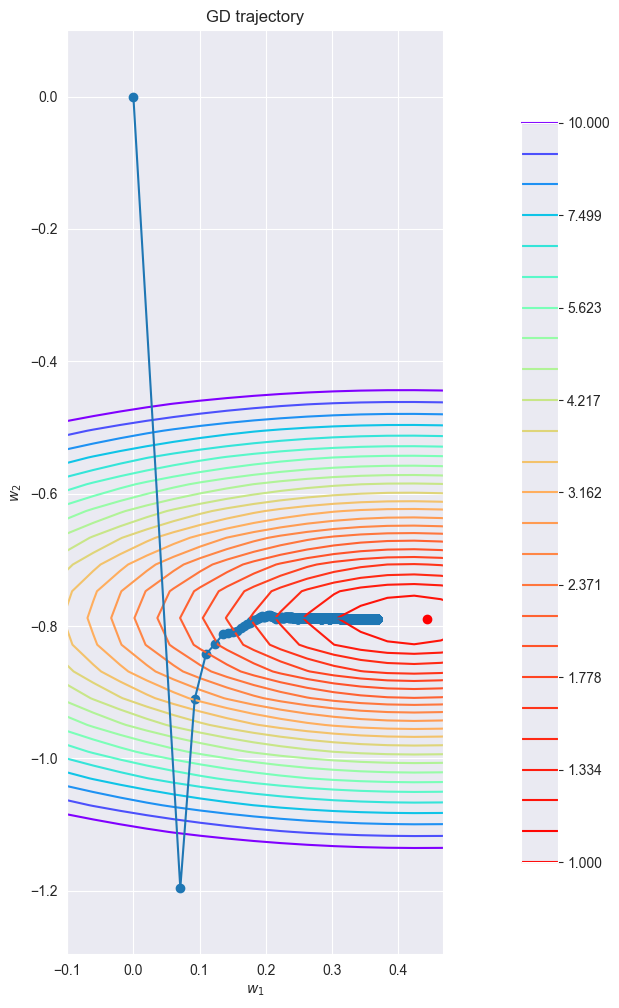

In [312]:
from matplotlib import pyplot as plt
# compute level set
A, B = np.meshgrid(np.linspace(-2, 2, 100), np.linspace(-2, 2, 100))

levels = np.empty_like(A)
for i in range(A.shape[0]):
    for j in range(A.shape[1]):
        w_tmp = np.array([A[i, j], B[i, j]])
        levels[i, j] = np.mean(np.power(np.dot(X, w_tmp) - Y, 2))


plt.figure(figsize=(20, 12))
plt.title('GD trajectory')
plt.xlabel(r'$w_1$')
plt.ylabel(r'$w_2$')
plt.xlim((temp_class.w_history[:, 0].min() - 0.1, temp_class.w_history[:, 0].max() + 0.1))
plt.ylim((temp_class.w_history[:, 1].min() - 0.1, temp_class.w_history[:, 1].max() + 0.1))
plt.gca().set_aspect('equal')

# visualize the level set
CS = plt.contour(A, B, levels, levels=np.logspace(0, 1, num=25), cmap=plt.cm.rainbow_r)
CB = plt.colorbar(CS, shrink=0.8, extend='both')

# visualize trajectory
plt.scatter(w_true[0], w_true[1], c='r')
plt.scatter(temp_class.w_history[:, 0], temp_class.w_history[:, 1])
plt.plot(temp_class.w_history[:, 0], temp_class.w_history[:, 1])

plt.show()

**Задание 3 (0 баллов)**
* Загрузите данные из домашнего задания 2 ([train.csv](https://www.kaggle.com/c/nyc-taxi-trip-duration/data));
* Разбейте выборку на обучающую и тестовую в отношении 7:3 с random_seed=0;
* Преобразуйте целевую переменную `trip_duration` как $\hat{y} = \log{(y + 1)}$.

In [11]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
# I decided to use already processed data
df = pd.read_csv("data/final_df_2nd_homework.csv")
df.info()

<class 'pandas.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 26 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  str    
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  str    
 3   passenger_count     1458644 non-null  int64  
 4   pickup_longitude    1458644 non-null  float64
 5   pickup_latitude     1458644 non-null  float64
 6   dropoff_longitude   1458644 non-null  float64
 7   dropoff_latitude    1458644 non-null  float64
 8   store_and_fwd_flag  1458644 non-null  int64  
 9   log_trip_duration   1458644 non-null  float64
 10  weekday             1458644 non-null  str    
 11  month               1458644 non-null  int64  
 12  hour                1458644 non-null  int64  
 13  day_year_number     1458644 non-null  int64  
 14  if_anomaly1         1458644 non-null  bool   
 15  if_anomaly2         145864

In [12]:
train_df, test_df = train_test_split(df, test_size=0.3, random_state=0)

**Задание 4 (3 балла)**. Обучите и провалидируйте модели на данных из предыдущего пункта, сравните качество между методами по метрикам MSE и $R^2$. Исследуйте влияние параметров `max_iter` и `eta` на процесс оптимизации. Согласуется ли оно с вашими ожиданиями?

In [21]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ
lin_ref = LinearReg(max_iter=10, gd_type='full')

**Задание 5 (6 балла)**. Постройте графики (на одной и той же картинке) зависимости величины функции потерь от номера итерации для всех реализованных видов стохастического градиентного спусков. Сделайте выводы о скорости сходимости различных модификаций градиентного спуска.

Не забывайте о том, что должны получиться *красивые* графики!

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 6 (бонус) (0.01 балла)**.  Вставьте картинку с вашим любимым мемом в этот Jupyter Notebook